In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle
import warnings

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from collections import Counter

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("zip_code_age.csv", index_col="Unnamed: 0")
kmeans = pickle.load(open("kmeans.pkl", "rb"))

In [3]:
df.head()

,female_0,female_1,female_2,female_3,female_4,female_5,female_6,female_7,female_8,female_9,...,male_94,male_95,male_96,male_97,male_98,male_99,male_100,male_101,male_102,cluster
10026,216,212,225,189,208,192,190,205,181,195,...,1,1,2,0,0,1,2,1,0,0
10027,354,329,320,323,308,270,291,284,280,284,...,6,3,4,1,2,0,0,0,0,1
10030,167,197,155,191,165,158,150,168,146,150,...,0,1,0,0,0,1,1,0,0,0
10037,81,101,94,93,92,87,64,83,78,83,...,4,4,2,3,1,0,3,0,0,2
10039,184,150,167,152,146,169,152,160,165,178,...,4,0,4,1,0,1,0,0,0,2


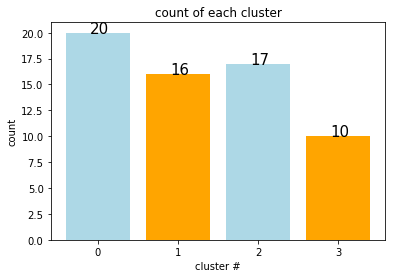

In [4]:
count = Counter(kmeans.best_estimator_.labels_)
x_cluster, y_height = zip(*count.items())

plt.bar(x=x_cluster, height=y_height, tick_label=x_cluster, color=["lightblue", "orange"])
for i, j in count.items(): plt.text(x=i-.1, y=j, s=j, fontdict={"fontsize": 15})
plt.ylabel("count")
plt.xlabel("cluster #")
plt.title("count of each cluster")
plt.show()

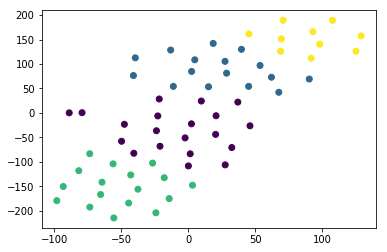

In [28]:
tsne_embedded = TSNE(n_components=2).fit_transform(df)
labels_km4 = kmeans.best_estimator_.labels_
plt.scatter(tsne_embedded[:,0], tsne_embedded[:,1], c=labels_km4)
plt.show()

**Define Age Group as `[0-5 6-11 12-17 18-23 24-29 30-35 36-41 42-47 48-53 54-59 60-65 66+]`**

In [6]:
def generate_age_group_colums(start, end):
    yield from [['female_%s'%age for age in range(start, end+1)], ['male_%s'%age for age in range(start, end+1)]]

In [8]:
age_groups = {(s,s+5): generate_age_group_colums(s, s+5)
              for s in range(0, 61, 6)}
age_groups[(66,102)] = generate_age_group_colums(65, 102)

In [9]:
age_groups

{(0, 5): <generator object generate_age_group_colums at 0x11749de60>,
 (6, 11): <generator object generate_age_group_colums at 0x11749df10>,
 (12, 17): <generator object generate_age_group_colums at 0x11749deb8>,
 (18, 23): <generator object generate_age_group_colums at 0x11749de08>,
 (24, 29): <generator object generate_age_group_colums at 0x11749ddb0>,
 (30, 35): <generator object generate_age_group_colums at 0x11749dd58>,
 (36, 41): <generator object generate_age_group_colums at 0x11749dd00>,
 (42, 47): <generator object generate_age_group_colums at 0x11749dc50>,
 (48, 53): <generator object generate_age_group_colums at 0x11749da40>,
 (54, 59): <generator object generate_age_group_colums at 0x11749dca8>,
 (60, 65): <generator object generate_age_group_colums at 0x11749df68>,
 (66, 102): <generator object generate_age_group_colums at 0x11749dfc0>}

In [10]:
def create_age_group(df, start, end):
    male_column = "male[%s-%s]" % (start, end)
    female_column = "female[%s-%s]" % (start, end)
    age_group = list(generate_age_group_colums(start, end))
    df[female_column] = np.sum(df[age_group[0]], axis=1)
    df[male_column] = np.sum(df[age_group[1]], axis=1)
    return df

In [11]:
for s, e in age_groups.keys():
    df = create_age_group(df, s, e)

In [12]:
age_group_columns=['%s[%s-%s]'%(g,s,e) for s, e in age_groups.keys() for g in ['female', 'male']]
df_age_gp = df[age_group_columns]
df_age_gp.head()

,female[0-5],male[0-5],female[6-11],male[6-11],female[12-17],male[12-17],female[18-23],male[18-23],female[24-29],male[24-29],...,female[42-47],male[42-47],female[48-53],male[48-53],female[54-59],male[54-59],female[60-65],male[60-65],female[66-102],male[66-102]
10026,1242,1141,1124,1201,1194,1171,1514,1425,2134,1773,...,1676,1609,1528,1432,1201,1071,911,699,1860,1071
10027,1904,1828,1707,1739,1896,1929,5573,4126,4402,3858,...,2388,2263,2184,1971,1939,1661,1476,1243,3329,1930
10030,1033,1058,951,982,1150,1165,1412,1258,1626,1334,...,1352,1136,1243,1078,924,833,703,527,1412,938
10037,548,504,471,529,590,610,741,664,969,741,...,867,647,829,603,782,468,693,449,1916,910
10039,968,1035,1006,1030,1086,1074,1195,1151,1283,1071,...,1154,977,1079,838,838,578,737,415,1727,839


## Cluster's Zip Code

In [13]:
C = [kmeans.best_estimator_.labels_==0,
     kmeans.best_estimator_.labels_==1,
     kmeans.best_estimator_.labels_==2,
     kmeans.best_estimator_.labels_==3]

In [14]:
cluster_zip_code = {i: df_age_gp[c].index for i, c in enumerate(C)}
"Cluster's Zip Code", cluster_zip_code

("Cluster's Zip Code",
 {0: Int64Index([10026, 10030, 10019, 10036, 10035, 10010, 10022, 10012, 10013,
              10014, 10021, 10028, 10065, 10075, 10034, 10040, 11205, 11217,
              11231, 11232],
             dtype='int64'),
  1: Int64Index([10027, 10011, 10016, 10003, 10009, 10128, 10023, 10024, 10031,
              10032, 10033, 11691, 11201, 11215, 11210, 11225],
             dtype='int64'),
  2: Int64Index([10037, 10039, 10001, 10018, 10020, 10017, 10004, 10005, 10006,
              10007, 10038, 10280, 10044, 11692, 11693, 11694, 11697],
             dtype='int64'),
  3: Int64Index([10029, 10002, 10025, 11204, 11218, 11219, 11230, 11203, 11226,
              11220],
             dtype='int64')})

In [15]:
pickle.dump(cluster_zip_code, open("cluster_zip_code.pkl", "wb"))

## Distribution of each Cluster

In [49]:
def plot_cluster_distribution(cluster_idx, gender=None):
    columns, colors = df_age_gp.columns, ['pink', "lightblue"]
    if gender is 0:  # female
        columns = columns[gender::2]  
        colors = ['pink']
    if gender is 1:  # male
        columns = columns[gender::2]  
        colors = ["lightblue"]
    
    c = kmeans.best_estimator_.labels_==cluster_idx
    plt.bar(columns, np.sum(df_age_gp[c][columns], axis=0)/np.sum(c), color=colors)
    plt.xticks(rotation=90)
    plt.ylabel("avg count per cluster")
    plt.title("Distribution of Cluster %s (Size: %s)"%(cluster_idx,np.sum(c)))
    plt.ylim([0, 8100])
#     plt.show()

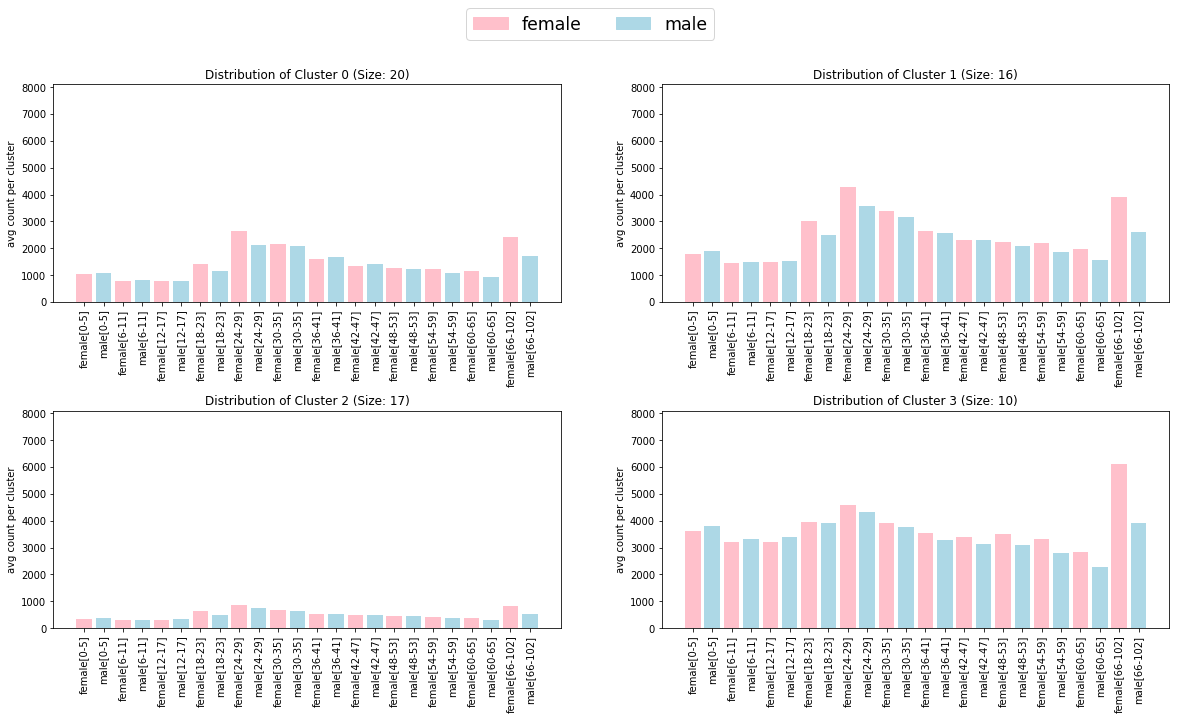

In [55]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.5)
plt.subplot(2,2,1); plot_cluster_distribution(cluster_idx=0)
plt.subplot(2,2,2); plot_cluster_distribution(cluster_idx=1)
plt.subplot(2,2,3); plot_cluster_distribution(cluster_idx=2)
plt.subplot(2,2,4); plot_cluster_distribution(cluster_idx=3)
pink_bar = mpatches.Patch(color='pink', label='female')
blue_bar = mpatches.Patch(color='lightblue', label='male')
plt.figlegend(handles=[pink_bar, blue_bar], loc='upper center', ncol=2, fontsize='xx-large')
plt.show()

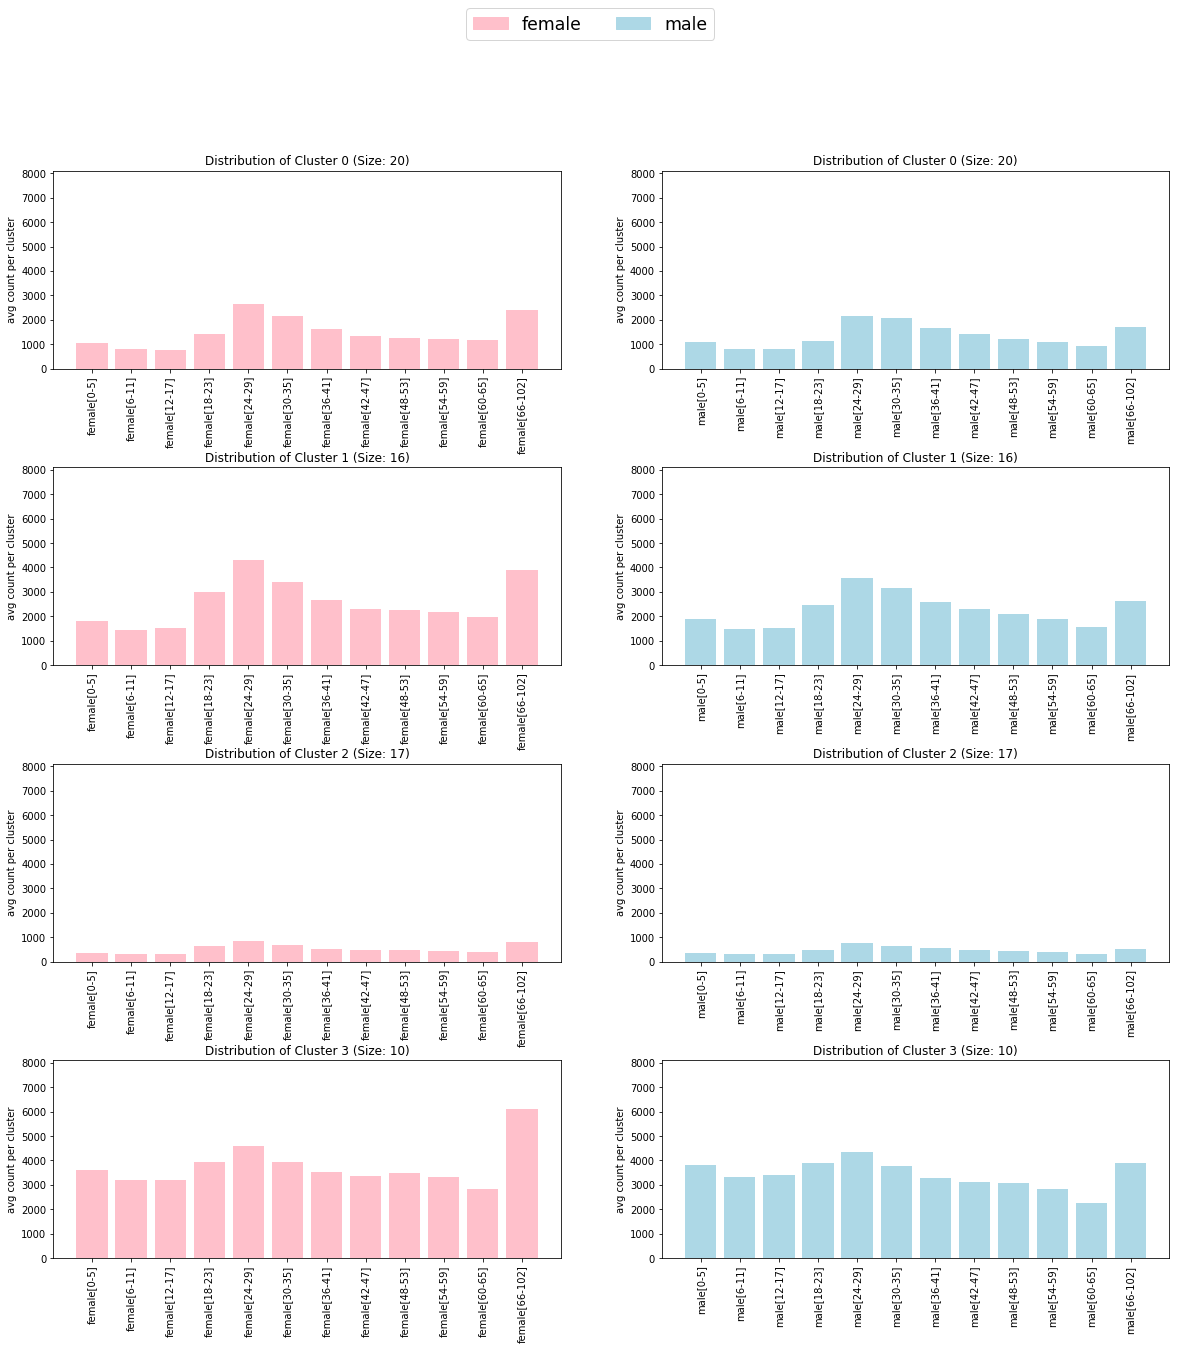

In [57]:
plt.figure(figsize=(20,20))
plt.subplots_adjust(hspace=0.5)
plt_i = 1
for idx in range(4):
    for g in range(2):
        plt.subplot(4, 2, plt_i)
        plot_cluster_distribution(cluster_idx=idx, gender=g)
        plt_i += 1
pink_bar = mpatches.Patch(color='pink', label='female')
blue_bar = mpatches.Patch(color='lightblue', label='male')
plt.figlegend(handles=[pink_bar, blue_bar], loc='upper center', ncol=2, fontsize='xx-large')
plt.show()